In [1]:
cd /content/drive/MyDrive/Precog_Task/

/content/drive/MyDrive/Precog_Task


In [ ]:
import numpy as np

def load_vec(path, max_vocab=50000):
    words = []
    embeddings = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        first_line = f.readline().strip().split()
        
        if len(first_line) == 2 and first_line[0].isdigit():
            pass  
        else:
            words.append(first_line[0])
            embeddings.append(np.array(list(map(float, first_line[1:])), dtype=np.float32))
        for i, line in enumerate(f):
            if i >= max_vocab:
                break
            parts = line.strip().split()
            if len(parts) < 10: 
                continue
            word = parts[0]
            vec = np.array(list(map(float, parts[1:])), dtype=np.float32)
            words.append(word)
            embeddings.append(vec)
    return words, np.vstack(embeddings)


In [3]:
en_words, en_emb = load_vec("wiki.en.vec", max_vocab=5000)   # English
hi_words, hi_emb = load_vec("wiki.hi.vec", max_vocab=5000)  # Hindi


In [4]:
en_word2id = {w: i for i, w in enumerate(en_words)}
hi_word2id = {w: i for i, w in enumerate(hi_words)}

In [5]:
print(en_word2id["december"])
print(hi_word2id["दिसंबर"])

146
951


In [6]:
seed = []
with open("en-hi.txt", "r", encoding="utf-8") as f:
    for line in f:
        en, hi = line.strip().split()
        if en in en_word2id and hi in hi_word2id:
            seed.append((en_word2id[en], hi_word2id[hi]))

In [7]:
print("Dictionary size used:", len(seed))

Dictionary size used: 3572


In [8]:
def learn_procrustes(X, Y):
    # X, Y: shape (n, d)
    M = X.T @ Y
    U, _, Vt = np.linalg.svd(M)
    W = U @ Vt
    return W

In [9]:
X = np.array([en_emb[i] for i, _ in seed])
Y = np.array([hi_emb[j] for _, j in seed])

In [10]:
W = learn_procrustes(X, Y)
print("Learned mapping W with shape:", W.shape)

Learned mapping W with shape: (300, 300)


In [11]:
en_mapped = en_emb @ W

In [12]:
def l2_normalize(mat):
    return mat / (np.linalg.norm(mat, axis=1, keepdims=True) + 1e-8)

en_mapped = l2_normalize(en_mapped)
hi_emb = l2_normalize(hi_emb)

In [13]:
def get_translation(word, k=5):
    if word not in en_word2id:
        return None
    idx = en_word2id[word]
    vec = en_mapped[idx]
    sims = hi_emb @ vec
    best = sims.argsort()[-k:][::-1]
    return [(hi_words[j], float(sims[j])) for j in best]

In [14]:
# Examples
for test_word in ["dog", "house", "water", "school"]:
    print(f"\nEnglish word: {test_word}")
    if test_word in en_word2id:
        translations = get_translation(test_word, k=5)
        for w, s in translations:
            print(f"  {w} ({s:.4f})")
    else:
        print("  Not in vocabulary")


English word: dog
  कुत्ते (0.6644)
  जानवर (0.5866)
  जानवरों (0.5026)
  पशु (0.4985)
  जंगली (0.4882)

English word: house
  हाउस (0.6089)
  मकान (0.5561)
  घर (0.5335)
  भवन (0.5015)
  कमरे (0.4690)

English word: water
  पानी (0.7322)
  जल (0.7202)
  गर्म (0.5184)
  सिंचाई (0.5167)
  पीने (0.4956)

English word: school
  स्कूल (0.7971)
  विद्यालय (0.7270)
  स्कूलों (0.6504)
  कॉलेज (0.6167)
  महाविद्यालय (0.6139)


In [15]:
def evaluate(dictionary, k=5):
    p1, p5 = 0, 0
    for en_idx, hi_idx in dictionary:
        vec = en_mapped[en_idx]
        sims = hi_emb @ vec
        best = sims.argsort()[-k:][::-1]
        if hi_idx == best[0]:
            p1 += 1
        if hi_idx in best:
            p5 += 1
    n = len(dictionary)
    return p1/n, p5/n

p1, p5 = evaluate(seed, k=5)

In [16]:
print(f"\nEvaluation on dictionary ({len(seed)} pairs):")
print(f"  Precision@1 = {p1*100:.2f}%")
print(f"  Precision@5 = {p5*100:.2f}%")



Evaluation on dictionary (3572 pairs):
  Precision@1 = 61.00%
  Precision@5 = 89.50%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2369 (\N{DEVANAGARI VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/li

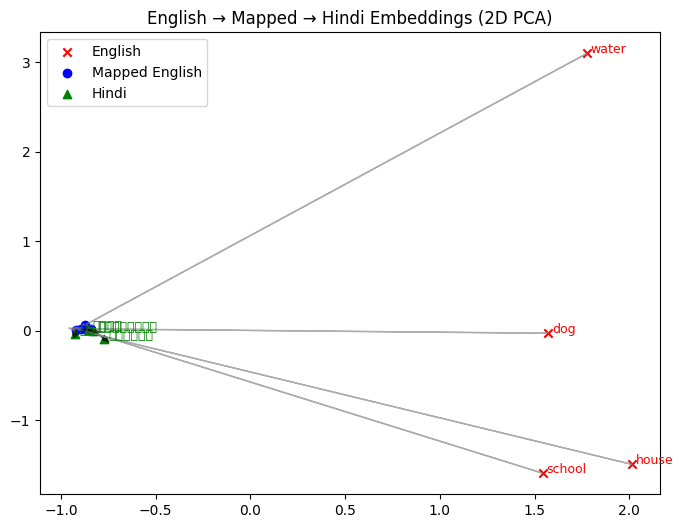

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Pick a few test words
test_words = ["dog", "cat", "house", "water", "school"]

points_en, points_mapped, points_hi, labels = [], [], [], []
for w in test_words:
    if w in en_word2id:
        en_idx = en_word2id[w]

        matches = [hi_idx for (ei, hi_idx) in seed if ei == en_idx]
        if not matches:
            continue
        hi_idx = matches[0]
        points_en.append(en_emb[en_idx])
        points_mapped.append(en_mapped[en_idx])
        points_hi.append(hi_emb[hi_idx])
        labels.append((w, hi_words[hi_idx]))


all_points = np.vstack([points_en, points_mapped, points_hi])
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_points)

n = len(points_en)
en_2d = reduced[:n]
mapped_2d = reduced[n:2*n]
hi_2d = reduced[2*n:]

plt.figure(figsize=(8, 6))
for i, (en_w, hi_w) in enumerate(labels):

    plt.scatter(en_2d[i,0], en_2d[i,1], c="red", marker="x", label="English" if i==0 else "")
    plt.text(en_2d[i,0]+0.02, en_2d[i,1], en_w, fontsize=9, color="red")

    plt.scatter(mapped_2d[i,0], mapped_2d[i,1], c="blue", marker="o", label="Mapped English" if i==0 else "")

    plt.scatter(hi_2d[i,0], hi_2d[i,1], c="green", marker="^", label="Hindi" if i==0 else "")
    plt.text(hi_2d[i,0]+0.02, hi_2d[i,1], hi_w, fontsize=9, color="green")

    plt.arrow(en_2d[i,0], en_2d[i,1],
              mapped_2d[i,0]-en_2d[i,0],
              mapped_2d[i,1]-en_2d[i,1],
              color="gray", alpha=0.6, width=0.002, head_width=0.03)
    plt.arrow(mapped_2d[i,0], mapped_2d[i,1],
              hi_2d[i,0]-mapped_2d[i,0],
              hi_2d[i,1]-mapped_2d[i,1],
              color="black", alpha=0.6, width=0.002, head_width=0.03)

plt.legend()
plt.title("English → Mapped → Hindi Embeddings (2D PCA)")
plt.show()


In [22]:
import numpy as np

def learn_linear_mapping(X, Y, reg=0.0):
    """
    Learn a linear mapping W such that XW ≈ Y
    X: (n, d) source embeddings (English)
    Y: (n, d) target embeddings (Hindi)
    reg: regularization strength (λ). Default 0 = no regularization.
    """
    d = X.shape[1]

    XtX = X.T @ X
    if reg > 0:
        XtX += reg * np.eye(d)
    W = np.linalg.inv(XtX) @ (X.T @ Y)
    return W

In [23]:

X = np.array([en_emb[i] for i, _ in seed])
Y = np.array([hi_emb[j] for _, j in seed])

# Learn linear mapping
W_lin = learn_linear_mapping(X, Y, reg=1e-5)
print("Linear mapping shape:", W_lin.shape)


en_mapped_lin = en_emb @ W_lin

en_mapped_lin = en_mapped_lin / (np.linalg.norm(en_mapped_lin, axis=1, keepdims=True) + 1e-8)

Linear mapping shape: (300, 300)


In [24]:
import numpy as np

def evaluate_mapping(W, en_emb, hi_emb, seed, k_list=[1,5]):
    """
    Evaluate a mapping matrix W using dictionary seed pairs.

    W: (d, d) mapping matrix
    en_emb: (n_en, d) English embeddings
    hi_emb: (n_hi, d) Hindi embeddings
    seed: list of (en_idx, hi_idx) pairs
    k_list: list of k values for precision@k
    """
    en_mapped = en_emb @ W

    en_mapped /= (np.linalg.norm(en_mapped, axis=1, keepdims=True) + 1e-8)
    hi_emb_norm = hi_emb / (np.linalg.norm(hi_emb, axis=1, keepdims=True) + 1e-8)


    X = np.array([en_mapped[i] for i, _ in seed])
    Y_idx = np.array([j for _, j in seed])

    sims = X @ hi_emb_norm.T

    results = {}
    for k in k_list:
        topk = np.argpartition(-sims, k, axis=1)[:, :k]
        correct = sum([Y_idx[i] in topk[i] for i in range(len(seed))])
        results[f"P@{k}"] = correct / len(seed)
    return results


In [25]:
print("Linear mapping:", evaluate_mapping(W_lin, en_emb, hi_emb, seed))

Linear mapping: {'P@1': 0.6013437849944009, 'P@5': 0.8824188129899216}


In [26]:
import numpy as np

hi_id2word = {idx: word for word, idx in hi_word2id.items()}

def get_translation_linear(word, en_emb, hi_emb, en_word2id, hi_id2word, k=5):
    """
    Get top-k translations of an English word using cosine similarity.

    Args:
        word (str): English word to translate
        en_emb (np.array): mapped English embeddings (n_words, d)
        hi_emb (np.array): Hindi embeddings (n_words, d)
        en_word2id (dict): mapping from English word -> index
        hi_id2word (dict): mapping from Hindi index -> word
        k (int): number of nearest neighbors to return

    Returns:
        List of (Hindi_word, similarity) tuples
    """
    if word not in en_word2id:
        return []

    idx = en_word2id[word]
    vec = en_emb[idx]

    hi_emb_norm = hi_emb / (np.linalg.norm(hi_emb, axis=1, keepdims=True) + 1e-8)


    sim = hi_emb_norm @ vec
    top_k_idx = np.argsort(sim)[-k:][::-1]

    results = [(hi_id2word[i], sim[i]) for i in top_k_idx]
    return results


In [27]:
for test_word in ["dog", "house", "water", "school"]:
    print(f"\nEnglish word: {test_word}")
    translations = get_translation_linear(
        test_word, en_mapped_lin, hi_emb, en_word2id, hi_id2word, k=5
    )
    if translations:
        for w, s in translations:
            print(f"  {w} ({s:.4f})")
    else:
        print("  Not in vocabulary")



English word: dog
  कुत्ते (0.7432)
  जानवर (0.6670)
  जानवरों (0.6154)
  पशु (0.5818)
  भालू (0.5813)

English word: house
  घर (0.6732)
  हाउस (0.6590)
  मकान (0.6545)
  कमरे (0.5907)
  भवन (0.5729)

English word: water
  पानी (0.8006)
  जल (0.7565)
  गर्म (0.6208)
  सिंचाई (0.6110)
  हवा (0.5678)

English word: school
  स्कूल (0.8344)
  विद्यालय (0.7475)
  स्कूलों (0.7389)
  कॉलेज (0.7080)
  महाविद्यालय (0.6943)


In [28]:
import numpy as np
from sklearn.cross_decomposition import CCA

def learn_cca_mapping(X, Y, n_components=100):
    """
    Learn CCA mapping for bilingual embeddings.

    Args:
        X: (n, d) matrix of English embeddings (seed dictionary aligned)
        Y: (n, d) matrix of Hindi embeddings
        n_components: latent dimension for CCA

    Returns:
        X_proj: projected English embeddings
        Y_proj: projected Hindi embeddings
        cca: trained CCA model
    """
    cca = CCA(n_components=n_components, max_iter=1000)
    X_proj, Y_proj = cca.fit_transform(X, Y)
    return X_proj, Y_proj, cca


# Example
X = np.array([en_emb[i] for i, _ in seed])
Y = np.array([hi_emb[j] for _, j in seed])


X_proj, Y_proj, cca_model = learn_cca_mapping(X, Y, n_components=100)
print("Projected English shape:", X_proj.shape)
print("Projected Hindi shape:", Y_proj.shape)


en_emb_cca, hi_emb_cca = cca_model.transform(en_emb, hi_emb)
print("CCA English vocab shape:", en_emb_cca.shape)
print("CCA Hindi vocab shape:", hi_emb_cca.shape)


Projected English shape: (3572, 100)
Projected Hindi shape: (3572, 100)
CCA English vocab shape: (5000, 100)
CCA Hindi vocab shape: (5000, 100)


In [29]:
import numpy as np

def get_translation_cca(word, en_emb_cca, hi_emb_cca, en_word2id, hi_id2word, k=5):
    """
    Retrieve top-k Hindi translations for a given English word in the CCA space.

    Args:
        word (str): English word to translate
        en_emb_cca (np.array): projected English embeddings (V_en, d)
        hi_emb_cca (np.array): projected Hindi embeddings (V_hi, d)
        en_word2id (dict): mapping from English word to index
        hi_id2word (dict): mapping from Hindi index to word
        k (int): number of translations to retrieve

    Returns:
        List of (Hindi word, cosine similarity) pairs
    """
    if word not in en_word2id:
        return []

    idx = en_word2id[word]
    query_vec = en_emb_cca[idx]


    sims = hi_emb_cca @ query_vec / (
        np.linalg.norm(hi_emb_cca, axis=1) * np.linalg.norm(query_vec) + 1e-8
    )


    top_k_idx = np.argsort(-sims)[:k]
    translations = [(hi_id2word[i], float(sims[i])) for i in top_k_idx]

    return translations

In [30]:
# Test words
for test_word in ["dog", "house", "water", "school"]:
    print(f"\nEnglish word: {test_word}")
    translations = get_translation_cca(
        test_word, en_emb_cca, hi_emb_cca, en_word2id, hi_id2word, k=5
    )
    if translations:
        for w, s in translations:
            print(f"  {w} ({s:.4f})")
    else:
        print("  Not in vocabulary")


English word: dog
  कुत्ते (0.8509)
  जानवर (0.6706)
  जानवरों (0.6397)
  भालू (0.6203)
  पशु (0.6120)

English word: house
  हाउस (0.8051)
  घर (0.7183)
  मकान (0.6777)
  घरों (0.6143)
  कमरे (0.5566)

English word: water
  पानी (0.8924)
  जल (0.8911)
  सिंचाई (0.6623)
  गर्म (0.6494)
  नदियों (0.5652)

English word: school
  स्कूल (0.9416)
  विद्यालय (0.8810)
  स्कूलों (0.8257)
  महाविद्यालय (0.7198)
  माध्यमिक (0.7151)


In [31]:
def evaluate_mapping_cca(en_emb_proj, hi_emb_proj, seed, k_list=[1,5]):
    # X: mapped English seed embeddings
    X = np.array([en_emb_proj[i] for i, _ in seed])
    Y_idx = np.array([j for _, j in seed])
    sims = X @ hi_emb_proj.T
    results = {}
    for k in k_list:
        topk = np.argpartition(-sims, k, axis=1)[:, :k]
        correct = sum([Y_idx[i] in topk[i] for i in range(len(seed))])
        results[f"P@{k}"] = correct / len(seed)
    return results

# Example usage
results_cca = evaluate_mapping_cca(en_emb_cca, hi_emb_cca, seed)
print("CCA mapping:", results_cca)

CCA mapping: {'P@1': 0.6122620380739082, 'P@5': 0.9185330347144457}
